# Practical Machine Learning for Physicists
## Week 2 Exercise: Training neural networks

Louis Marinho Fernandes

GitHub Repositary: https://github.com/Louis100000000/PHAS0056

## 1. Introduction

This week, we will train neural networks to mimic specific shapes: a circle; a circle with another circle of a different colour within the first one (a circle with a hole); a cicrcle with three holes. The algorithms will be followed by a discussion of the choices that have been made regarding the code.

## 2. Defining the functions we will need

We start by importing the modules that will be needed for the task: [1]

In [1]:
#from numpy import array, zeros, exp, random, dot, shape, reshape, meshgrid, linspace
import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# for subplots within subplots:
from matplotlib import gridspec

# for nice inset colorbars: (approach changed from lecture 1 'Visualization' notebook)
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

# for updating display 
# (very simple animation)
from IPython.display import clear_output
from time import sleep

We then define all the functions that will be needed to define and train our neural networks:

In [2]:
# backpropagation and training routines

# this is basically a merger of the backpropagation
# code shown in lecture 2 and some of the 
# visualization code used in the lecture 1 tutorials!

def net_f_df(z,activation):
    # return both value f(z) and derivative f'(z)
    if activation=='sigmoid':
        return([1/(1+np.exp(-z)), 
                1/((1+np.exp(-z))*(1+np.exp(z))) ])
    elif activation=='jump': # cheating a bit here: replacing f'(z)=delta(z) by something smooth
        return([np.array(z>0,dtype='float'), 
                10.0/((1+np.exp(-10*z))*(1+np.exp(10*z))) ] )
    elif activation=='linear':
        return([z,
                1.0])
    elif activation=='reLU':
        return([(z>0)*z,
                (z>0)*1.0
               ])

def forward_step(y,w,b,activation):
    """
    Go from one layer to the next, given a 
    weight matrix w (shape [n_neurons_in,n_neurons_out])
    a bias vector b (length n_neurons_out)
    and the values of input neurons y_in 
    (shape [batchsize,n_neurons_in])
    
    returns the values of the output neurons in the next layer 
    (shape [batchsize, n_neurons_out])
    """    
    # calculate values in next layer, from input y
    z=np.dot(y,w)+b # w=weights, b=bias vector for next layer
    return(net_f_df(z,activation)) # apply nonlinearity and return result

def apply_net(x_in): # one forward pass through the network
    global Weights, Biases, NumLayers, Activations
    global y_layer, df_layer # for storing y-values and df/dz values
    
    y=np.copy(x_in) # start with input values
    y_layer[0]=np.copy(y)
    for j in range(NumLayers): # loop through all layers
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,Weights[j],Biases[j],Activations[j]) # one step
        df_layer[j]=np.copy(df) # store f'(z) [needed later in backprop]
        y_layer[j+1]=np.copy(y) # store f(z) [also needed in backprop]        
    return(y)

def apply_net_simple(x_in): # one forward pass through the network
    # no storage for backprop (this is used for simple tests)
    global Weights, Biases, NumLayers, Activations
    
    y=x_in # start with input values
    for j in range(NumLayers): # loop through all layers
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,Weights[j],Biases[j],Activations[j]) # one step
    return(y)

def backward_step(delta,w,df): 
    # delta at layer N, of batchsize x layersize(N))
    # w between N-1 and N [layersize(N-1) x layersize(N) matrix]
    # df = df/dz at layer N-1, of batchsize x layersize(N-1)
    return( np.dot(delta,np.transpose(w))*df )

def backprop(y_target): # one backward pass through the network
    # the result will be the 'dw_layer' matrices that contain
    # the derivatives of the cost function with respect to
    # the corresponding weight
    global y_layer, df_layer, Weights, Biases, NumLayers
    global dw_layer, db_layer # dCost/dw and dCost/db (w,b=weights,biases)

    batchsize=np.shape(y_target)[0]
    delta=(y_layer[-1]-y_target)*df_layer[-1]
    dw_layer[-1]=np.dot(np.transpose(y_layer[-2]),delta)/batchsize
    db_layer[-1]=delta.sum(0)/batchsize
    for j in range(NumLayers-1):
        delta=backward_step(delta,Weights[-1-j],df_layer[-2-j])
        dw_layer[-2-j]=np.dot(np.transpose(y_layer[-3-j]),delta)/batchsize # batchsize was missing in old code?
        db_layer[-2-j]=delta.sum(0)/batchsize
        
def gradient_step(eta): # update weights & biases (after backprop!)
    global dw_layer, db_layer, Weights, Biases
    
    for j in range(NumLayers):
        Weights[j]-=eta*dw_layer[j]
        Biases[j]-=eta*db_layer[j]
        
def train_net(x_in,y_target,eta): # one full training batch
    # x_in is an array of size batchsize x (input-layer-size)
    # y_target is an array of size batchsize x (output-layer-size)
    # eta is the stepsize for the gradient descent
    global y_out_result
    
    y_out_result=apply_net(x_in)
    backprop(y_target)
    gradient_step(eta)
    cost=0.5*((y_target-y_out_result)**2).sum()/np.shape(x_in)[0]
    return(cost)

def init_layer_variables(weights,biases,activations):
    global Weights, Biases, NumLayers, Activations
    global LayerSizes, y_layer, df_layer, dw_layer, db_layer

    Weights=weights
    Biases=biases
    Activations=activations
    NumLayers=len(Weights)

    LayerSizes=[2]
    for j in range(NumLayers):
        LayerSizes.append(len(Biases[j]))

    y_layer=[[] for j in range(NumLayers+1)]
    df_layer=[[] for j in range(NumLayers)]
    dw_layer=[np.zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
    db_layer=[np.zeros(LayerSizes[j+1]) for j in range(NumLayers)]


In [3]:
# visualization routines:

# some internal routines for plotting the network:
def plot_connection_line(ax,X,Y,W,vmax=1.0,linewidth=3):
    t=np.linspace(0,1,20)
    if W>0:   #Pick colour of line based on if weight is positive or negative
        col=[0,0.4,0.8]  
    else:
        col=[1,0.3,0]
    ax.plot(X[0]+(3*t**2-2*t**3)*(X[1]-X[0]),Y[0]+t*(Y[1]-Y[0]),
           alpha=abs(W)/vmax,color=col,
           linewidth=linewidth)
    
def plot_neuron_alpha(ax,X,Y,B,size=100.0,vmax=1.0):
    if B>0: #Pick colour of neuron dot based on if bias is positive or negative
        col=[0,0.4,0.8]
    else:
        col=[1,0.3,0]
    ax.scatter([X],[Y],marker='o',c=np.atleast_2d([col]),alpha=abs(B)/vmax,s=size,zorder=10)

def plot_neuron(ax,X,Y,B,size=100.0,vmax=1.0):
    if B>0:
        col=[0,0.4,0.8]
    else:
        col=[1,0.3,0]
    ax.scatter([X],[Y],marker='o',c=np.atleast_2d([col]),s=size,zorder=10)
    
def visualize_network(weights,biases,activations,
                      M=100,x0range=[-1,1],x1range=[-1,1],
                     size=400.0, linewidth=5.0,
                     weights_are_swapped=False,
                    layers_already_initialized=False,
                      plot_cost_function=None,
                      current_cost=None, cost_max=None, plot_target=None
                     ):
    """
    Visualize a neural network with 2 input 
    neurons and 1 output neuron (plot output vs input in a 2D plot)
    
    weights is a list of the weight matrices for the
    layers, where weights[j] is the matrix for the connections
    from layer j to layer j+1 (where j==0 is the input)
    
    weights[j][m,k] is the weight for input neuron k going to output neuron m
    (note: internally, m and k are swapped, see the explanation of
    batch processing in lecture 2)
    
    biases[j] is the vector of bias values for obtaining the neurons in layer j+1
    biases[j][k] is the bias for neuron k in layer j+1
    
    activations is a list of the activation functions for
    the different layers: choose 'linear','sigmoid',
    'jump' (i.e. step-function), and 'reLU'
    
    M is the resolution (MxM grid)
    
    x0range is the range of x0 neuron values (horizontal axis)
    x1range is the range of x1 neuron values (vertical axis)
    """
    if not weights_are_swapped:
        swapped_weights=[]
        for j in range(len(weights)):
            swapped_weights.append(np.transpose(weights[j]))
    else:
        swapped_weights=weights

    x0,x1=np.meshgrid(np.linspace(x0range[0],x0range[1],M),np.linspace(x1range[0],x1range[1],M))
    x_in=np.zeros([M*M,2])
    x_in[:,0]=x0.flatten()
    x_in[:,1]=x1.flatten()
    
    # if we call visualization directly, we still
    # need to initialize the 'Weights' and other
    # global variables; otherwise (during training)
    # all of this has already been taken care of:
    if not layers_already_initialized:
        init_layer_variables(swapped_weights,biases,activations)
    y_out=apply_net_simple(x_in)

    if plot_cost_function is None:
        fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(8,4))
    else:
        fig=plt.figure(figsize=(8,4))
        gs_top = gridspec.GridSpec(nrows=1, ncols=2)
        gs_left = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=1, subplot_spec=gs_top[0], height_ratios=[1.0,0.3])
        ax=[ fig.add_subplot(gs_left[0]),
            fig.add_subplot(gs_top[1]),
           fig.add_subplot(gs_left[1]) ]
        # ax[0] is network
        # ax[1] is image produced by network
        # ax[2] is cost function subplot
        
    # plot the network itself:
    
    # positions of neurons on plot:
    posX=[[-0.5,+0.5]]; posY=[[0,0]]
    vmax=0.0 # for finding the maximum weight
    vmaxB=0.0 # for maximum bias
    for j in range(len(biases)):
        n_neurons=len(biases[j])
        posX.append(np.array(range(n_neurons))-0.5*(n_neurons-1))
        posY.append(np.full(n_neurons,j+1))
        vmax=np.maximum(vmax,np.max(np.abs(weights[j])))
        vmaxB=np.maximum(vmaxB,np.max(np.abs(biases[j])))

    # plot connections
    for j in range(len(biases)):
        for k in range(len(posX[j])):
            for m in range(len(posX[j+1])):
                plot_connection_line(ax[0],[posX[j][k],posX[j+1][m]],
                                     [posY[j][k],posY[j+1][m]],
                                     swapped_weights[j][k,m],vmax=vmax,
                                    linewidth=linewidth)
    
    # plot neurons
    for k in range(len(posX[0])): # input neurons (have no bias!)
        plot_neuron(ax[0],posX[0][k],posY[0][k],
                   vmaxB,vmax=vmaxB,size=size)
    for j in range(len(biases)): # all other neurons
        for k in range(len(posX[j+1])):
            plot_neuron(ax[0],posX[j+1][k],posY[j+1][k],
                       biases[j][k],vmax=vmaxB,size=size)
    
    ax[0].axis('off')
    
    # now: the output of the network
    img=ax[1].imshow(np.reshape(y_out,[M,M]),origin='lower',
                    extent=[x0range[0],x0range[1],x1range[0],x1range[1]])
    ax[1].set_xlabel(r'$x_0$')
    ax[1].set_ylabel(r'$x_1$')
    
#     axins1 = inset_axes(ax[1],
#                     width="40%",  # width = 50% of parent_bbox width
#                     height="5%",  # height : 5%
#                     loc='upper right',
#                        bbox_to_anchor=[0.3,0.4])

#    axins1 = ax[1].inset_axes([0.5,0.8,0.45,0.1])
    axins1 = plt.axes([0, 0, 1, 1])
    ip = InsetPosition(ax[1], [0.25, 0.1, 0.5, 0.05])
    axins1.set_axes_locator(ip)

    imgmin=np.min(y_out)
    imgmax=np.max(y_out)
    color_bar=fig.colorbar(img, cax=axins1, orientation="horizontal",ticks=np.linspace(imgmin,imgmax,3))
    cbxtick_obj = plt.getp(color_bar.ax.axes, 'xticklabels')
    plt.setp(cbxtick_obj, color="white")
    axins1.xaxis.set_ticks_position("bottom")

    if plot_target is not None:
        axins2 = plt.axes([0.01, 0.01, 0.99, 0.99])
        ip = InsetPosition(ax[1], [0.75, 0.75, 0.2, 0.2])
        axins2.set_axes_locator(ip)
        axins2.imshow(plot_target,origin='lower')
        axins2.get_xaxis().set_ticks([])
        axins2.get_yaxis().set_ticks([])
        
    if plot_cost_function is not None:
        ax[2].plot(plot_cost_function)
        ax[2].set_ylim([0.0,cost_max])
        ax[2].set_yticks([0.0,cost_max])
        ax[2].set_yticklabels(["0",'{:1.2e}'.format(cost_max)])
        if current_cost is not None:
            ax[2].text(0.9, 0.9, 'cost={:1.2e}'.format(current_cost), horizontalalignment='right',
                       verticalalignment='top', transform=ax[2].transAxes)
    
    plt.show()
    
def visualize_network_training(weights,biases,activations,
                               target_function,
                               num_neurons=None,
                               weight_scale=1.0,
                               bias_scale=1.0,
                               xspread=1.0,
                      M=100,x0range=[-1,1],x1range=[-1,1],
                     size=400.0, linewidth=5.0,
                    steps=100, batchsize=10, eta=0.1,
                              random_init=False,
                              visualize_nsteps=1,
                              plot_target=True):
    """
    Visualize the training of a neural network.
    
    weights, biases, and activations define the neural network 
    (the starting point of the optimization; for the detailed description,
    see the help for visualize_network)
    
    If you want to have layers randomly initialized, just provide
    the number of neurons for each layer as 'num_neurons'. This should include
    all layers, including input (2 neurons) and output (1), so num_neurons=[2,3,5,4,1] is
    a valid example. In this case, weight_scale and bias_scale define the
    spread of the random Gaussian variables used to initialize all weights and biases.
    
    target_function is the name of the function that we
    want to approximate; it must be possible to 
    evaluate this function on a batch of samples, by
    calling target_function(y) on an array y of 
    shape [batchsize,2], where
    the second index refers to the two coordinates
    (input neuron values) x0 and x1. The return
    value must be an array with one index, corresponding
    to the batchsize. A valid example is:
    
    def my_target(y):
        return( np.sin(y[:,0]) + np.cos(y[:,1]) )
    
    steps is the number of training steps
    
    batchsize is the number of samples per training step
    
    eta is the learning rate (stepsize in the gradient descent)
    
    xspread denotes the spread of the Gaussian
    used to sample points in (x0,x1)-space
    
    visualize_n_steps>1 means skip some steps before
    visualizing again (can speed up things)
    
    plot_target=True means do plot the target function in a corner
    
    For all the other parameters, see the help for
        visualize_network
    
    weights and biases as given here will be used
    as starting points, unless you specify
    random_init=True, in which case they will be
    used to determine the spread of Gaussian random
    variables used for initialization!
    """
    
    if num_neurons is not None: # build weight matrices as randomly initialized
        weights=[weight_scale*np.random.randn(num_neurons[j+1],num_neurons[j]) for j in range(len(num_neurons)-1)]
        biases=[bias_scale*np.random.randn(num_neurons[j+1]) for j in range(len(num_neurons)-1)]
    
    swapped_weights=[]
    for j in range(len(weights)):
        swapped_weights.append(np.transpose(weights[j]))
    init_layer_variables(swapped_weights,biases,activations)
    
    if plot_target:
        x0,x1=np.meshgrid(np.linspace(x0range[0],x0range[1],M),np.linspace(x1range[0],x1range[1],M))
        y=np.zeros([M*M,2])
        y[:,0]=x0.flatten()
        y[:,1]=x1.flatten()
        plot_target_values=np.reshape(target_function(y),[M,M])
    else:
        plot_target_values=None
    
    y_target=np.zeros([batchsize,1])
    costs=np.zeros(steps)
    
    for j in range(steps):
        # produce samples (random points in x0,x1-space):
        x_in=xspread*np.random.randn(batchsize,2)
        # apply target function to those points:
        y_target[:,0]=target_function(x_in)
        # do one training step on this batch of samples:
        costs[j]=train_net(x_in,y_target,eta)
        
        # now visualize the updated network:
        if j%visualize_nsteps==0:
            clear_output(wait=True) # for animation
            if j>10:
                cost_max=np.average(costs[0:j])*1.5
            else:
                cost_max=costs[0]
            visualize_network(Weights,Biases,activations,
                          M,x0range=x0range,x1range=x1range,
                         size=size, linewidth=linewidth,
                             weights_are_swapped=True,
                             layers_already_initialized=True,
                             plot_cost_function=costs,
                             current_cost=costs[j],
                             cost_max=cost_max,
                             plot_target=plot_target_values)
            sleep(0.1) # wait a bit before next step (probably not needed)

We are now ready to start training our first neural network.

## 3. Circle target

Our first goal is to train a neural network that will mimic the shape of a circle:

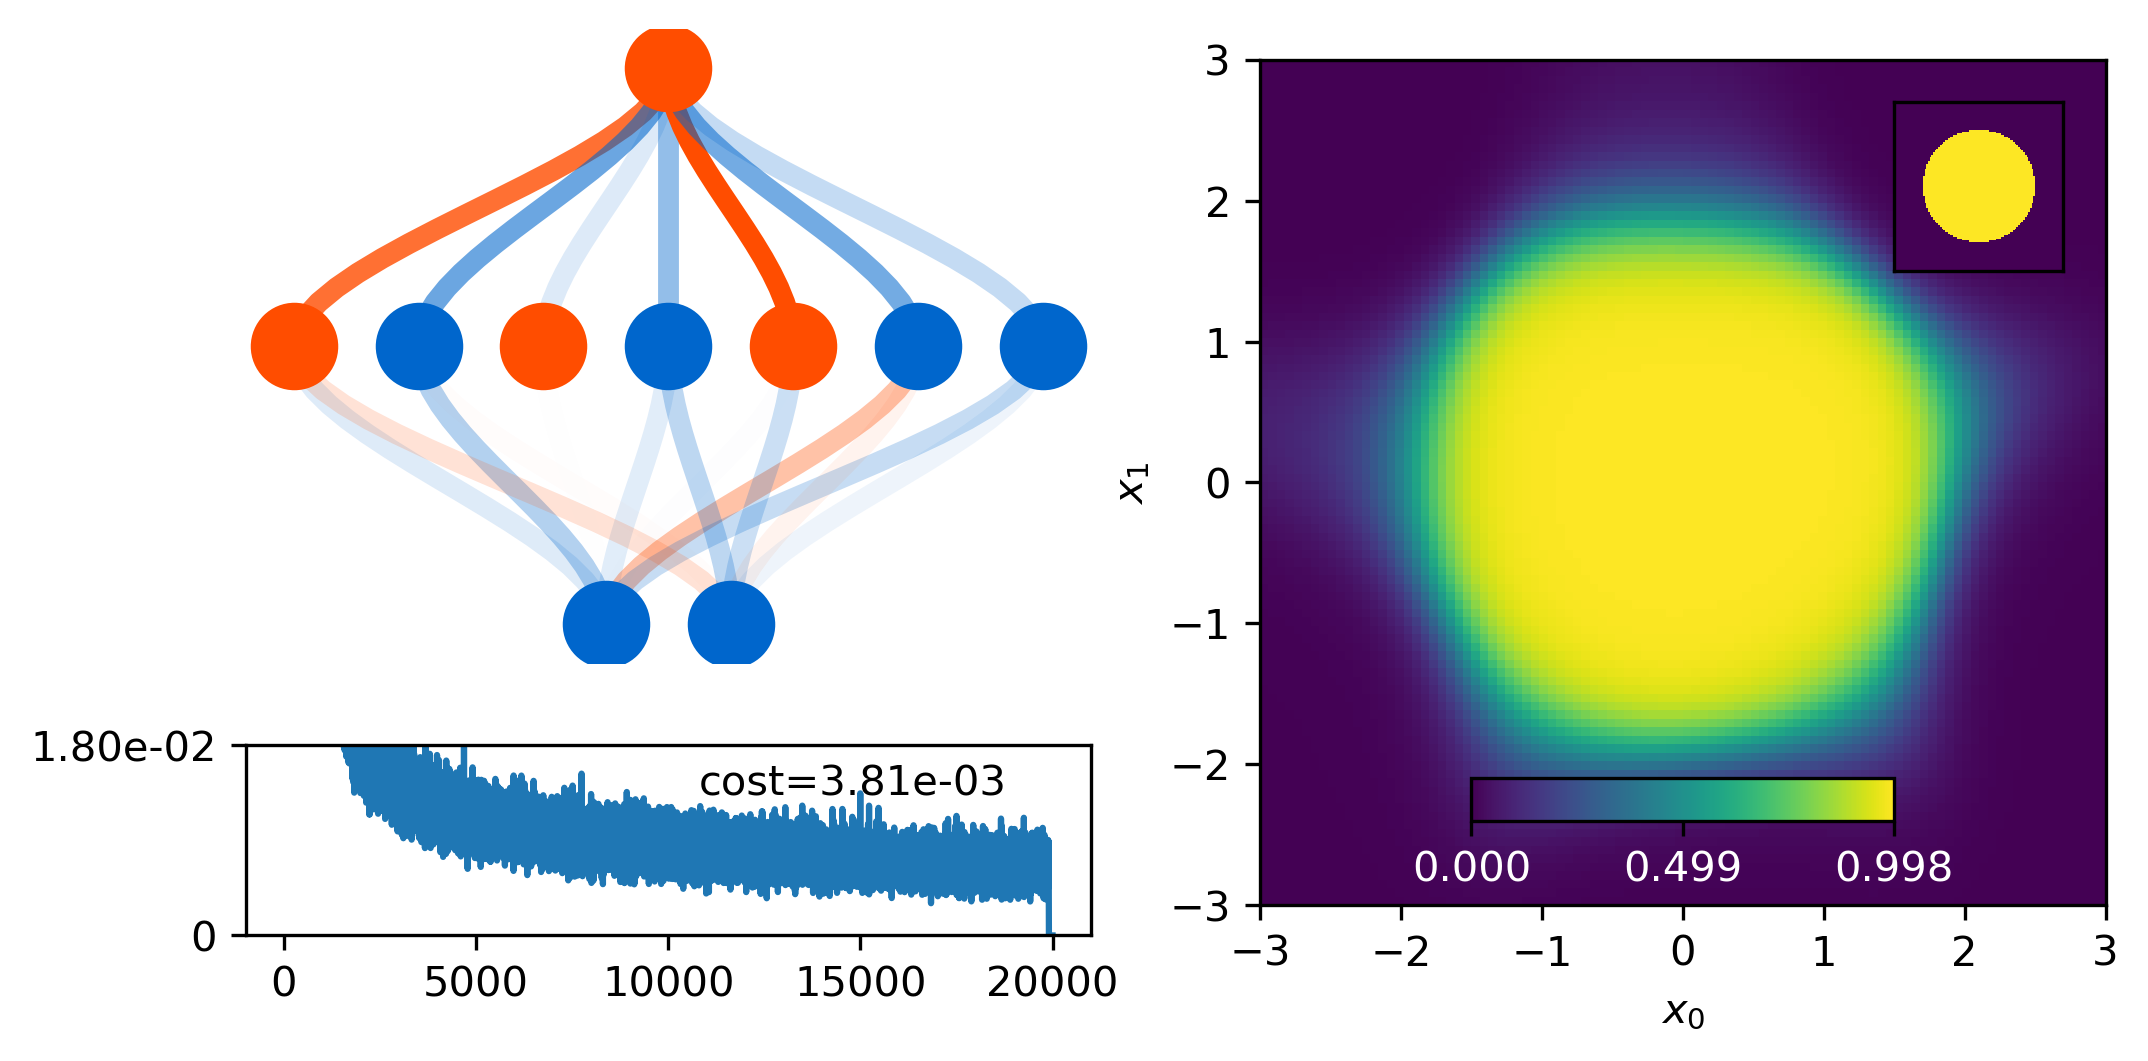

In [11]:
### We start by defining the target function for the circle:

def circle_target(x):
    '''This target function takes in a variable x and returns a circle
    of radius R = 2.0'''
    R=2.0
    return( 1.0*( x[:,0]**2+x[:,1]**2<R**2 )) 

### We now use our previously defined visualize_network_training function to train our neural network and to 
### visualize both the network itself and its training:

visualize_network_training(weights=[ [ 
    [1,1],[0.3,0.4]  # weights of the two input neurons for the single output neuron
    ],
    [  [0.2,0.5]  ]  # weights of the ingle output neuron
    ],
    biases=[ 
        [0.1,-0.2], # biases for the two input neurons
        [0.0] # bias for the single output neuron
            ],
    target_function=circle_target, # the target function we try to approximate
    num_neurons=[2,7,1], # 2 input neurons, 7 neurons in a single hidden layer, 1 output neuron
    activations=[ 'sigmoid',  # activation function for the hidden layer
                  'sigmoid'   #  activation function for the output
                 ],
    x0range=[-3,3],  # range of x0 neuron values
    x1range=[-3,3],  # range of x1 neuron values
    xspread=3,  # spread of the Gaussian used to sample points in (x0,x1)-space
    steps=20000,  # number of training steps
    eta=1, # learning rate
    batchsize=300,  # number of samples per steps
    visualize_nsteps=100)   # for visualization purposes

On the top left of the screen, the neural network itself is visualized: each point corresponds to a neuron, and the lines are the connections between them. On the bottom left of the screen, we can see the evolution of the cost function. On the right of the screen, the output of the network is sivualized.

We need two inputs (x0 and x1) to plot a 2D circle, and one output for the colour (to distinguish the circle from the background). We found that having no hidden layer does not lead to a satisfying result (the shaped obtained is not circular). Moreover, the shapes drawn by the network start to look roughly like a circle when there are only 5 neurons in the hidden layer, but the they remain a bit spiky and are not completely round; having 7 neurons for the hidden layer yields a more satisfying circle. Using a sigmoid function both for the hidden layer and for the output leads to a satisfying shape. We choose a batchsize of 300, as taking more samples per step leads to a smoother circle. We set the learning rate at 1. Finally, having less training steps than 20000 decreases the quality of our circle, but having more decreases the efficiency of the code (by increasing the time needed to process it) without significantly improving the shape of the circle: we therefore set the number of steps at 20000.

## 4. Circle hole target

We will now train a neural network that will mimic a circle with a hole within it:

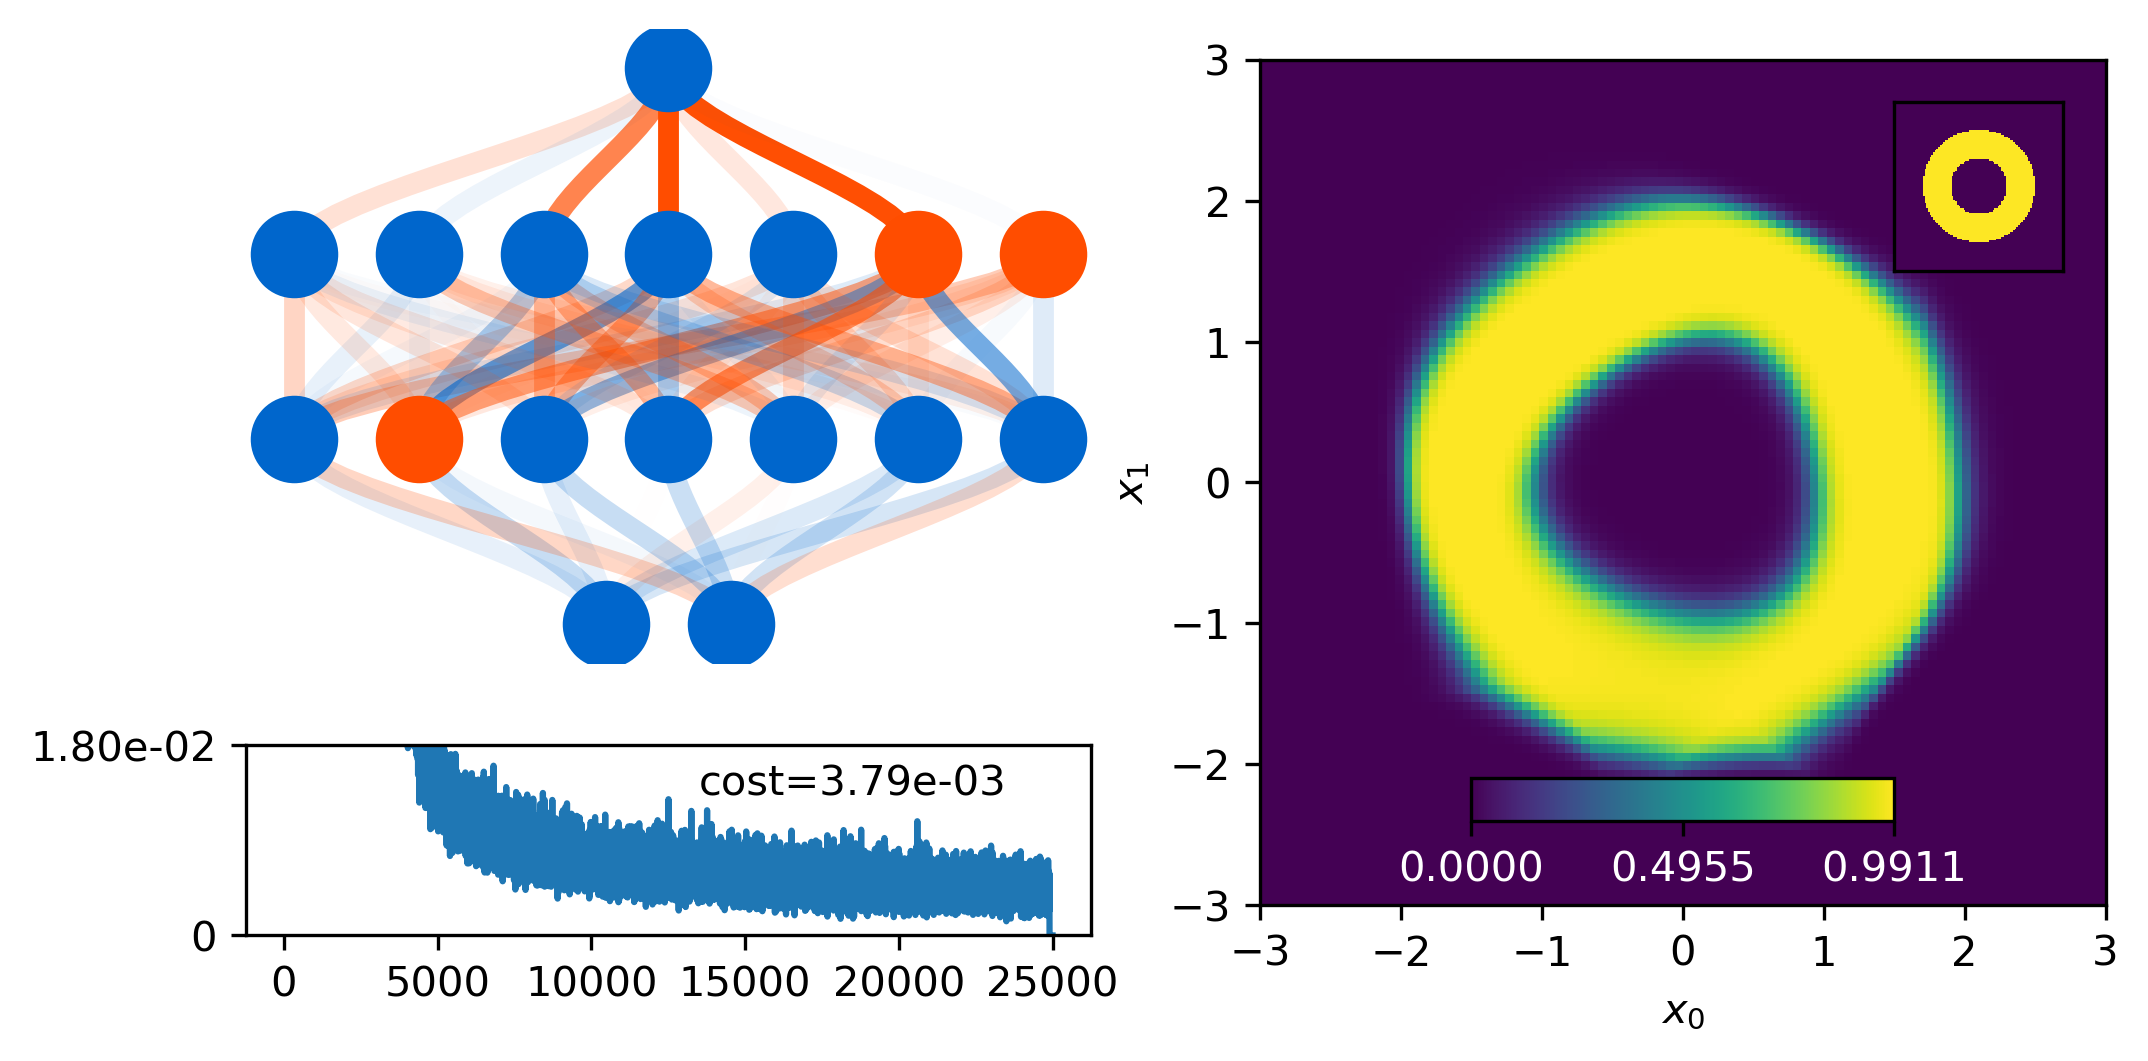

In [10]:
### We start by defining the target function for the circle with a hole:


def circle_hole_target(x):
    '''This target function takes in a variable x and returns a circle
    of radius R = 2.0 with a hole or radius r = 1.0 around the origin'''
    r=1.0; R=2.0
    return( 1.0*( x[:,0]**2+x[:,1]**2<R**2 ) - 1.0*( (x[:,0])**2+(x[:,1])**2<r**2))

### We now use our previously defined visualize_network_training function to train our neural network and to 
### visualize both the network itself and its training:

visualize_network_training(weights=[ [ 
    [],[]  # defaut weights of the two input neurons 
    ],
    [  [0.5,0.5]  ] # weights of the single output neuron
    ],
    biases=[ 
        [0.1,-0.2], # biases for the two output neurons
        [0.0] # bias for the single output neuron
            ],
    target_function=circle_hole_target,# the target function we try to approximate
    num_neurons=[2,7,7,1], # 2 input neurons, 7 neurons in the first hidden layer, 7 neurons in the second
                           # hidden layer, 1 output neuron
    activations=[ 'sigmoid', 'reLU', 'sigmoid'], # activation function for the first hidden layer, 
                                                 # for the second hidden layer,
                                                 # for the output
                    
    x0range=[-3,3],  # range of x0 neuron values
    x1range=[-3,3],  # range of x1 neuron values
    xspread=3,  # spread of the Gaussian used to sample points in (x0,x1)-space
    steps=25000,  # number of training steps
    eta=1.0, # learning rate
    batchsize=400,  # number of samples per steps
    visualize_nsteps=100)   # for visualization purposes

We need two inputs (x0 and x1) to plot a 2D circle and the 2D hole, and one output for the colour (to distinguish the circle from the hole and the background). We found that having no hidden layer or only one does not lead to a satisfying result. Moreover, as in the section before, the shapes drawn by the network start to look roughly like a circle when there are only 5 neurons in the hidden layer, but the shape remains a bit spiky and not completely round; having 7 neurons for the hidden layer yield a more satisfying circle and hole. We choose a batchsize of 400. Using a sigmoid function for the first hidden layer and the ouput while using a reLU function for the second hidden layer lead to better shapes than using only sigmoids or reLU functions. Finally, having less than 25000 training steps would significantly decrease the quality of the shapes.

## 5. Scream target

Finally, we will train a network tha twill mimic a circle which has three smaller circles (or holes) within it; the whole drawing therefore looks like a screaming face:

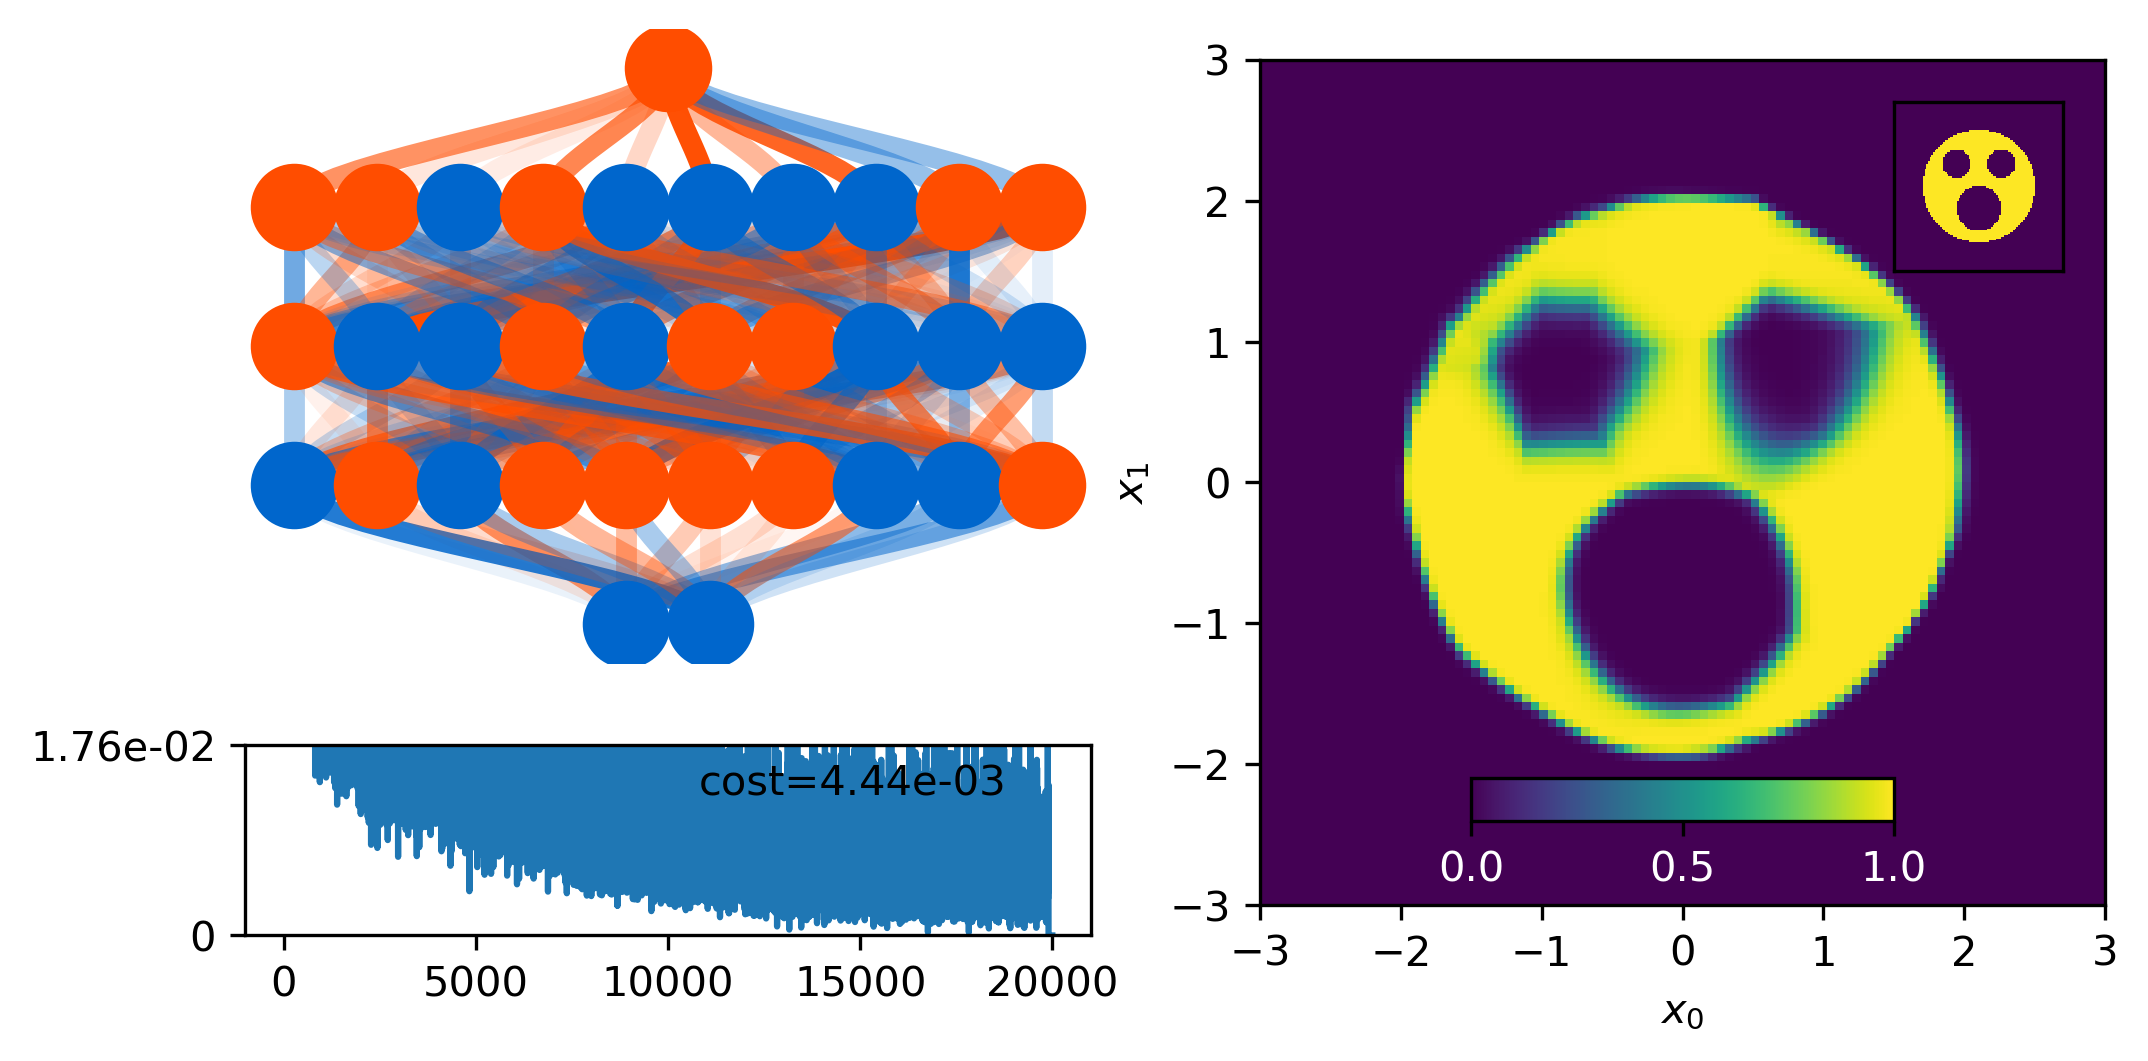

In [8]:
### We start by defining the target function for the circle with three holes:

def scream_target(x): 
    '''This target function takes in a variable x and returns a circle
    of radius R = 2.0 (the face) with two small holes of radius r = 0.5 (the eyes)
    and a bigger hole of radius r2 (the mouth)'''
    a=0.8; r=0.5; R=2.0; r2=0.8
    return( 1.0*( x[:,0]**2+x[:,1]**2<R**2 ) - 1.0*( (x[:,0]-a)**2+(x[:,1]-a)**2<r**2) - 1.0*( (x[:,0]+a)**2+(x[:,1]-a)**2<r**2 ) - 1.0*( (x[:,0])**2+(x[:,1]+a)**2<r2**2 ) )


### We now use our previously defined visualize_network_training function to train our neural network and to 
### visualize both the network itself and its training:


visualize_network_training(weights=[ [ 
    [],[]  # defaut weights of the two input neurons 
    ],
    [  [0.5,0.5]  ]  # weights of the single output neuron
    ],
    biases=[ 
        [0.1,-0.2],  # biases for for the two output neurons
        [0.0] # bias for single output neuron
            ],
    target_function=scream_target, # the target function we try to approximate
    num_neurons=[2,10,10,10, 1], # 2 input neurons, 10 neurons in the first hidden layer, 10 neurons in the second 
                                 # hidden layer, 10 neurons in the third hidden layer, 1 output neuron
    activations=[ 'sigmoid', 
                 'reLU', 'reLU', 'sigmoid'
                ], # # activation function for the first hidden layer, 
                                                 # for the second hidden layer,
                                                 # for the output
                    
    x0range=[-3,3],  # range of x0 neuron values
    x1range=[-3,3],  # range of x1 neuron values
    xspread=3,   # spread of the Gaussian used to sample points in (x0,x1)-space
    steps=20000,  # number of training steps
    eta=1, # learning rate
    batchsize=300, # number of samples per steps
    visualize_nsteps=100) # for visualization purposes

We need two inputs (x0 and x1) to plot a 2D circle and the 2D holes (the eyes and the mouth), and one output for the colour (to distinguish the circle from the holes and the background). We found that having less than two hidden layers does not lead to a satisfying result. Moreover, having less than 10 neurons per layers leads to seemingly arbitrary shapes. Using a sigmoid function for the first hidden layer and the ouput while using a reLU function for the second  and the third hidden layer lead to better shapes than using only sigmoids or reLU functions. Finally, having less than 20000 training steps would significantly decrease the quality of the shapes. 

## 6. Conclusion

We have have trained neural networks to mimic various circular shapes. For each of these shapes, the network we trained had different features (number of hidden layers, number of hidden neurons in each hidden layer, activation functions, etc.), and the parameters of the trainings also differ. We note that finding the optimal parameters for both the network and the training necessitates to find a balance between the efficiency of the code (how quickly it will be run by the computer) and how accurately the shapes are drawn.

## 7. References:

[1] PHAS0056: Practical Machine Learning for Physicists, Week2_NetworkVisualisation.ipynb notebook, Ryan Nichol, https://colab.research.google.com/github/nichol77/mlForPhysicists/blob/master/Week2/Week2_NetworkVisualisation.ipynb, accessed 19/10/2020